# Unit04｜Train/Test Split、標準化與 ML 流程（建模前半）

對應講義：`Part_1/Unit04_ML_Preprocessing_Workflow.md`


In [1]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
# Part_1 課程結果儲存在 Part_1 資料夾內
PART1_DIR = REPO_ROOT / 'Part_1'
OUTPUT_DIR = PART1_DIR / 'Unit04_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(PART1_DIR)
print('REPO_ROOT:', REPO_ROOT)
print('PART1_DIR:', PART1_DIR)
print('Working dir:', os.getcwd())
print('Results will be saved to:', OUTPUT_DIR)


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
PART1_DIR: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1
Working dir: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1
Results will be saved to: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_1\Unit04_Results


## 1) 建一個「化工風格」的 i.i.d. 範例資料

假設我們要用操作條件（T/P/F）預測「批次是否達標」(0/1)。


In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)
n = 800

# 操作條件（不同量級：故意讓 scaling 有差）
T = np.random.normal(350, 8, n)          # K
P = np.random.normal(10, 1.2, n)         # bar
F = np.random.normal(1200, 180, n)       # kg/h

# 達標機率（示意：溫度太低/太高都不好；壓力略有幫助；流量太高可能不好）
score = (
    -0.015*(T-350)**2
    + 0.18*(P-10)
    - 0.0015*(F-1200)
    + np.random.normal(0, 0.8, n)
)
prob = 1/(1+np.exp(-score))
y = (prob > 0.5).astype(int)

X = pd.DataFrame({'T_K': T, 'P_bar': P, 'F_kgph': F})
print(X.head())
print('y mean (pass rate):', y.mean())


          T_K      P_bar       F_kgph
0  353.973713  11.125941  1167.078641
1  348.893886   9.380746  1447.477755
2  355.181508  10.115345  1083.726448
3  362.184239   9.445270  1056.145439
4  348.126773   9.478605  1113.106166
y mean (pass rate): 0.28375


## 2) i.i.d. 資料：隨機 Train/Test Split + Pipeline


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300)),
])

model.fit(X_train, y_train)
print('train acc:', model.score(X_train, y_train))
print('test  acc:', model.score(X_test, y_test))


train acc: 0.7421875
test  acc: 0.74375


## 3) Data Leakage 示範：錯誤的標準化方式

錯誤做法：先用全部資料 `fit_transform`，再切 Train/Test。

這在真實專案中常會讓你「以為模型很準」，但其實偷看了測試集資訊。


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler_bad = StandardScaler()
X_scaled_bad = scaler_bad.fit_transform(X)  # ❌ 先 fit 在全資料

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_scaled_bad, y, test_size=0.2, random_state=42, shuffle=True
)

clf_bad = LogisticRegression(max_iter=300)
clf_bad.fit(X_train_b, y_train_b)
print('test acc (leaky scaling):', clf_bad.score(X_test_b, y_test_b))
print('Note: This number can be optimistic because scaling used test-set statistics.')


test acc (leaky scaling): 0.74375
Note: This number can be optimistic because scaling used test-set statistics.


## 4) 時間序列：不能亂 shuffle（時間洩漏）

用一個簡化的連續製程時間序列示意：若隨機切分，模型會看到「未來狀態」的分佈。


Fold 1: test acc = 0.890 (train up to t=99)
Fold 2: test acc = 0.590 (train up to t=199)
Fold 3: test acc = 0.620 (train up to t=299)
Fold 4: test acc = 0.910 (train up to t=399)
Fold 5: test acc = 0.990 (train up to t=499)
Mean acc: 0.8


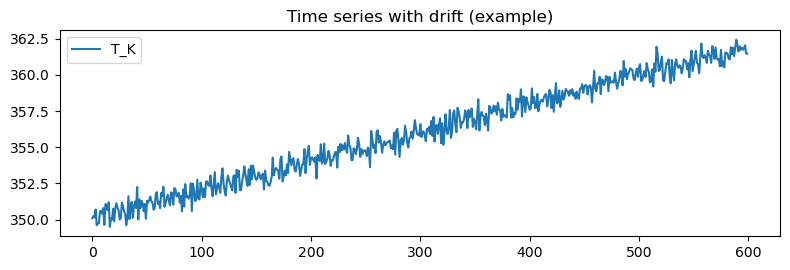

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

n_ts = 600
t = np.arange(n_ts)

# 製程逐漸漂移：溫度 slowly drift；壓力與流量有週期
T_ts = 350 + 0.02*t + np.random.normal(0, 0.5, n_ts)
P_ts = 10 + 0.6*np.sin(2*np.pi*t/120) + np.random.normal(0, 0.15, n_ts)
F_ts = 1200 + 60*np.cos(2*np.pi*t/90) + np.random.normal(0, 20, n_ts)

# 目標：下一步是否會超過某個風險門檻（示意）
# 使用更平衡的閾值，確保各個時間段都有兩個類別
risk_score = 0.6*(T_ts-350) + 0.8*(P_ts-10) + np.random.normal(0, 1.2, n_ts)
y_ts = (risk_score > np.quantile(risk_score, 0.5)).astype(int)  # 使用中位數，更平衡

X_ts = pd.DataFrame({'T_K': T_ts, 'P_bar': P_ts, 'F_kgph': F_ts})

ts_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=300)),
])

tscv = TimeSeriesSplit(n_splits=5)
scores = []
for fold, (tr, te) in enumerate(tscv.split(X_ts), 1):
    ts_model.fit(X_ts.iloc[tr], y_ts[tr])
    scores.append(ts_model.score(X_ts.iloc[te], y_ts[te]))
    print(f'Fold {fold}: test acc = {scores[-1]:.3f} (train up to t={tr[-1]})')

print('Mean acc:', float(np.mean(scores)))

plt.figure(figsize=(8, 2.8))
plt.plot(T_ts, label='T_K')
plt.title('Time series with drift (example)')
plt.legend()
plt.tight_layout()
plt.savefig('Unit04_Results/ts_example.png', dpi=140, bbox_inches='tight')
plt.show()
